In [1]:
import coldatoms
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

The input configuration for the ions is given by the following data set:

In [2]:
input_configuration = np.loadtxt('inputIonConfiguration.dat')

This is a matrix the rows corresponding to x, y, z, vx, vy, vz, charge, and mass. For example, the first particle has the following state:

In [3]:
input_configuration[:,0]

array([  1.00799552e-05,  -9.47328408e-06,  -9.52882956e-44,
         2.61945844e+00,   2.78756571e+00,   2.38067112e-37,
         1.60217660e-19,   1.49674940e-26])

Now we need to convert this input a coldatoms ensemble:

In [4]:
def create_ensemble(configuration):
    ensemble = coldatoms.Ensemble(configuration.shape[1])
    ensemble.x = np.ascontiguousarray(np.transpose(configuration[0:3, :]))
    ensemble.v = np.ascontiguousarray(np.transpose(configuration[3:6, :]))
    ensemble.ensemble_properties['charge'] = configuration[6, 0]
    ensemble.ensemble_properties['mass'] = configuration[7, 0]
    return ensemble

In [5]:
ensemble = create_ensemble(input_configuration)

In [6]:
print(ensemble.num_ptcls)
print(ensemble.x.shape)

127
(127, 3)


Here is a top view of the ion crystal:

<IPython.core.display.Javascript object>


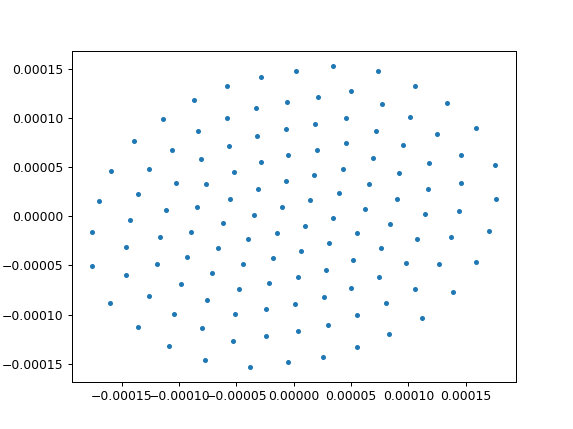

In [7]:
plt.plot(ensemble.x[:, 0], ensemble.x[:, 1], 'o', ms=3);

We need to rotate the cloud so that its major axis are aligned with the coordinate axis:

In [8]:
def rotate(xy, phase):
    return np.column_stack((
            xy[:, 0] * np.cos(phase) - xy[:, 1] * np.sin(phase),
            xy[:, 0] * np.sin(phase) + xy[:, 1] * np.cos(phase)
            ))

<IPython.core.display.Javascript object>


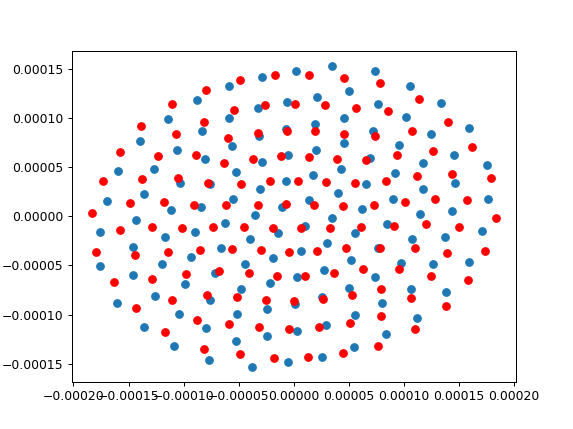

In [9]:
positions = ensemble.x
plt.figure()
plt.plot(positions[:,0], positions[:,1],'o')
rotated = rotate(positions[:,:2], -0.3)
plt.plot(rotated[:,0], rotated[:,1],'ro')

The strongest forces in our system are the Coulomb force and the Lorentz force due to the axial magnetic fields in the Penning trap:

In [10]:
coulomb_force = coldatoms.CoulombForce()

## Axial Penning trap field

One of the essential components of a Penning trap is a strong magnetic fields that bends the ions' trajectories leading to confinement. For our numerical treatment of the ions the magnetic field poses a problem. The accuracy of the drift-kick integrator used in some of the other examples is only first order and the integrator is no longer symplectic. Fundamentally this is because the Lorentz force in a magnetic field is velocity dependent. Thus our forces now contain both momentum and position dependent terms. The simple momentum kick implemented in the drift kick integrator is no longer an exact integration of the force terms. Hence the loss of accuracy and stability.

To see this computationally we can represent the Lorentz force due to the axial magnetic field by the following class:

In [11]:
class AxialLorentzForce(object):
    """Lorentz force due to axial magnetic field in Penning trap."""
    
    def __init__(self, b_field):
        self.b_field = b_field
        
    def force(self, dt, ensemble, f):
        q = ensemble.ensemble_properties['charge']
        if q is None:
            q = ensemble.particle_properties['charge']
            if q is None:
                raise RuntimeError('Must provide ensemble or per particle charge')
            
        f += dt * self.b_field * np.column_stack(
            (q * ensemble.v[:, 1], -q * ensemble.v[:, 0], np.zeros_like(ensemble.x[:, 0])))

The old Penning trap in the ion storage group at NIST had a field strenght of 4.458 Tesla:

In [12]:
lorentz_force = AxialLorentzForce(4.458)

With no other forces acting on the particle we expect it to execute cyclotron motion. In the x-y plance the particle ought to move on a circle. Integreting the motion of a single ion now using the drift-kick integrator we find the following:

The expected gyro radius is:
2.09555297581e-07


<IPython.core.display.Javascript object>


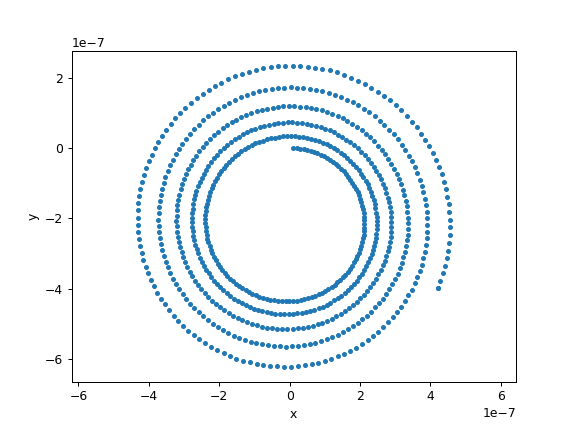

In [13]:
m = ensemble.ensemble_properties['mass']
q = ensemble.ensemble_properties['charge']
B = lorentz_force.b_field
v = 10.0 # m/s
print('The expected gyro radius is:')
print(m * v / (q * B))

test_ensemble = coldatoms.Ensemble(1)
test_ensemble.v[0, 0] = v
test_ensemble.ensemble_properties['mass'] = m
test_ensemble.ensemble_properties['charge'] = q

f = np.zeros_like(test_ensemble.v)
lorentz_force.force(1.0e-9, test_ensemble, f)

positions = [test_ensemble.x[0]]
dt = 1.0e-9
for i in range(700):
    coldatoms.drift_kick(dt, test_ensemble, [lorentz_force])
    positions.append(np.copy(test_ensemble.x[0]))

positions = np.array(positions)
plt.figure()
plt.plot(positions[:, 0], positions[:, 1], 'o', ms=3);
plt.xlabel('x')
plt.ylabel('y')
plt.axes().set_aspect('equal', 'datalim')

The ion initially moves on a circular trajectory in agreement with the theoretical prediction. By and by its speed increases as is evident by the increasing spacing between successive positions. As the speed increases the cyclotron radius increases and the ion spirals further and further out.

There are several well documented and researched integrators that do not suffer from these accuracy issues and which maintain symplecticity. Perhaps the most well known is the so called Boris advance. However, for our purposes it is not a great fit because we need to combine the electromagnetic forces with several other forces some of which are not conservative such as the radiation pressure force with its damping and fluctuating components. Furthermore, some of the other forces are position dependent while others are momentum dependent, ruining the very special structure needed for the Boris update.

Instead we use a different splitting of the particle dynamics where we combine the magnetic force with the kinetic energy. The free evolution in the constant magnetic field is the already mentioned gyrotron motion which we can integrate exactly. This alternative integration scheme is sometimes referred to as a bend-kick integrator, alluding to the fact that the free particle motion is along bent trajectories. In the coldatoms library this integrator is implemented in the bend_kick function:

<IPython.core.display.Javascript object>


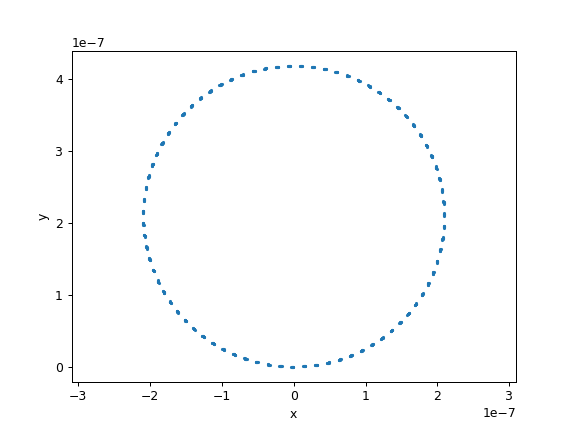

In [16]:
m = ensemble.ensemble_properties['mass']
q = ensemble.ensemble_properties['charge']
B = lorentz_force.b_field
v = 10.0 # m/s

test_ensemble = coldatoms.Ensemble(1)
test_ensemble.v[0, 0] = v
test_ensemble.ensemble_properties['mass'] = m
test_ensemble.ensemble_properties['charge'] = q

positions = [test_ensemble.x[0]]
dt = 1.0e-7
for i in range(600):
    coldatoms.bend_kick(dt, B, test_ensemble, [])
    positions.append(np.copy(test_ensemble.x[0]))

positions = np.array(positions)
plt.figure()
plt.plot(positions[:, 0], positions[:, 1], '.', ms=3);
plt.xlabel('x')
plt.ylabel('y')
plt.axes().set_aspect('equal', 'datalim')

The cyclotron frequency is

In [26]:
omega_cyclotron = ensemble.ensemble_properties['charge'] * 4.458 / ensemble.ensemble_properties['mass']

With a period of 

In [27]:
2.0 * np.pi / omega_cyclotron

1.316674766805686e-07

In [31]:
class TrapPotential(object):

    def __init__(self, kz, delta, omega, phi_0):
        self.kz = kz
        self.kx = -(0.5 + delta) * kz
        self.ky = -(0.5 - delta) * kz
        self.phi = phi_0
        self.omega = omega
        
    def force(self, dt, ensemble, f):
        self.phi += self.omega * 0.5 * dt
        
        q = ensemble.ensemble_properties['charge']
        if q is None:
            q = ensemble.particle_properties['charge']
            if q is None:
                raise RuntimeError('Must provide ensemble or per particle charge')

        cphi = np.cos(self.phi)
        sphi = np.sin(self.phi)
        kx = self.kx
        ky = self.ky
        
        f[:, 0] += dt * q * (
            (-kx * cphi * cphi - ky * sphi * sphi) * ensemble.x[:, 0] +
            cphi * sphi * (ky - kx) * ensemble.x[:, 1])
        f[:, 1] += dt * q * (
            cphi * sphi * (ky - kx) * ensemble.x[:, 0] +
            (-kx * sphi * sphi - ky * cphi * cphi) * ensemble.x[:, 1])
        f[:, 2] += -dt * q *self.kz * ensemble.x[:, 2]

        self.phi += self.omega * 0.5 * dt

In [32]:
trap_potential = TrapPotential(2.0 * 1.167e6, 0.0036, 2.0 * np.pi * 44.0e3, 0.3)

In [34]:
f = np.zeros_like(ensemble.x)
trap_potential.force(1.0e-9, ensemble, f)
print(f[0])
print(ensemble.v[0])
print(ensemble.v[0] + f[0]/ensemble.ensemble_properties['mass'])

[  1.88867325e-27  -1.75306697e-27   3.56328693e-65]
[  2.61945844e+00   2.78756571e+00   2.38067112e-37]
[  2.74564344e+00   2.67044076e+00   2.40447796e-37]


# Convergence

First we convince we investigate the error as a function of the time step size to figure out how small of a time step size we need to choose to reasonable accuracy.

In [35]:
def evolve_ensemble(dt, t_max, ensemble, forces):
    t = 0
    while t < t_max:
        coldatoms.drift_kick(dt, ensemble, forces)
        t += dt

<IPython.core.display.Javascript object>


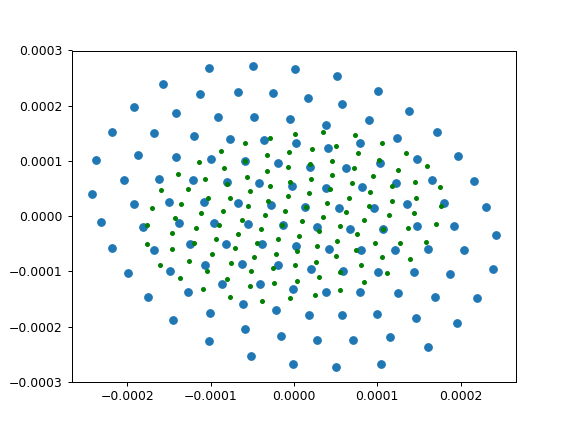

In [47]:
my_ensemble = create_ensemble(input_configuration)
trap_potential.phi = 0.3

evolve_ensemble(5.0e-10, 7.5e-6, my_ensemble, [coulomb_force, lorentz_force, trap_potential])

plt.figure()
plt.plot(my_ensemble.x[:,0], my_ensemble.x[:,1], 'o')
plt.plot(ensemble.x[:,0], ensemble.x[:,1], 'go', ms=3)

<IPython.core.display.Javascript object>


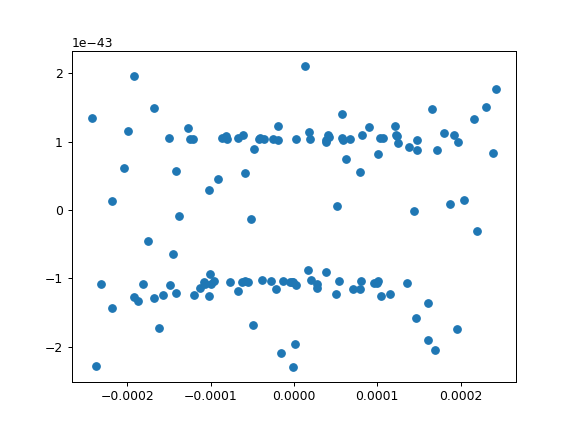

In [48]:
plt.figure()
plt.plot(my_ensemble.x[:,0], my_ensemble.x[:,2], 'o')